In [1]:
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

import torch

import pandas as pd

from src.utils import plot_embeddings, plot_confusion_matrix, performance_metrics, ms_label2id, ms_id2label, load_ms_data

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [2]:
def show_results(file_name: str) -> None:
    results = torch.load(paths.RESULTS_PATH / "ms-diag" / f"{file_name}")
    # Last hidden states is a list of tensors of shape (seq_len, hidden_size)
    last_hidden_state = [batch[0, :] for batch in results["last_hidden_state"]]  # Use CLS token
    embeddings = torch.stack(last_hidden_state, dim=0).to(torch.float16)
    labels = [ms_id2label[label] for label in results["labels"]]
    preds = [ms_id2label[pred] for pred in results["preds"]]

    # Plot confusion matrix
    plot_confusion_matrix(preds=preds, labels=labels, title=file_name)
    plt.show()

    # Plot embeddings
    plot_embeddings(embeddings=embeddings, labels=labels, title=file_name)
    plt.show()

    # Print classification report
    print(classification_report(y_true=labels, y_pred=preds), "\n\n")

    # Show all wrongly classified samples
    for i in range(len(labels)):
        if labels[i] != preds[i]:
            print(f"Label: {labels[i]} - Prediction: {preds[i]}")
            print(results["text"][i], "\n\n")

# MedBERT 512

## Strategy: Classify on single lines, 4 Labels (including no MS) and oversampling for training

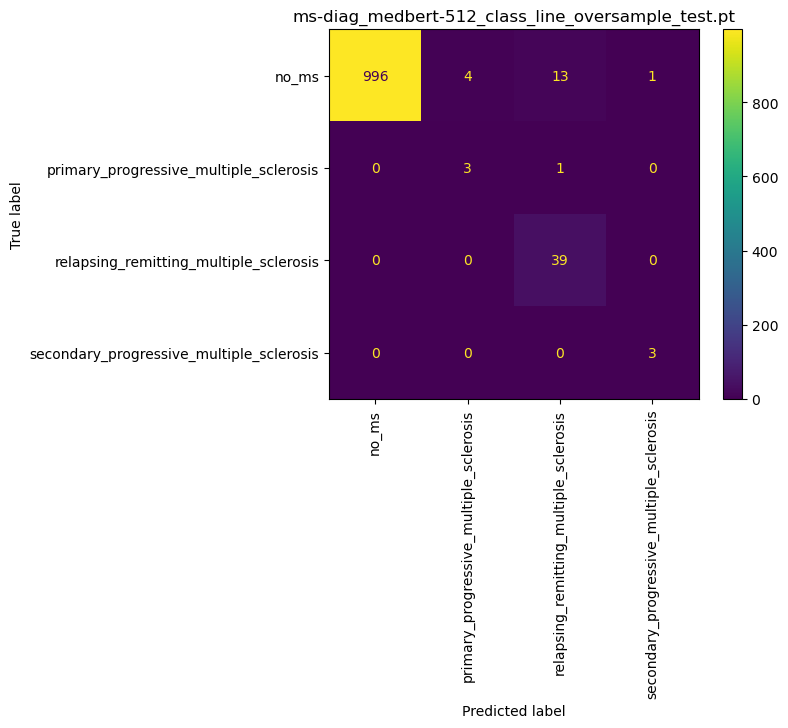

(1060, 2)


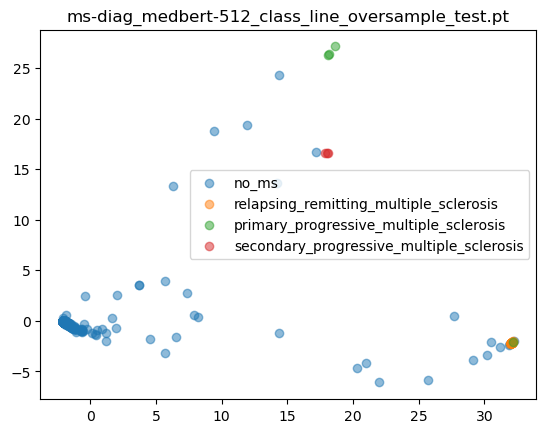

                                          precision    recall  f1-score   support

                                   no_ms       1.00      0.98      0.99      1014
  primary_progressive_multiple_sclerosis       0.43      0.75      0.55         4
  relapsing_remitting_multiple_sclerosis       0.74      1.00      0.85        39
secondary_progressive_multiple_sclerosis       0.75      1.00      0.86         3

                                accuracy                           0.98      1060
                               macro avg       0.73      0.93      0.81      1060
                            weighted avg       0.99      0.98      0.98      1060
 


Label: no_ms - Prediction: primary_progressive_multiple_sclerosis
Aktuell (02/2019): Klinisch nicht aktiv, radiologisch aktiv,  Progression ja (nach Lublin et al. 2013) 


Label: no_ms - Prediction: relapsing_remitting_multiple_sclerosis
INDENT cMRI Schädel 30 01.2017: progrediente MS mit multiplen, teils konfluierenden neu aufgetretene

In [3]:
show_results("ms-diag_medbert-512_class_line_oversample_test.pt")

## Strategy: Classify on single lines, 3 Labels (original approach with only dm samples) and oversampling for training

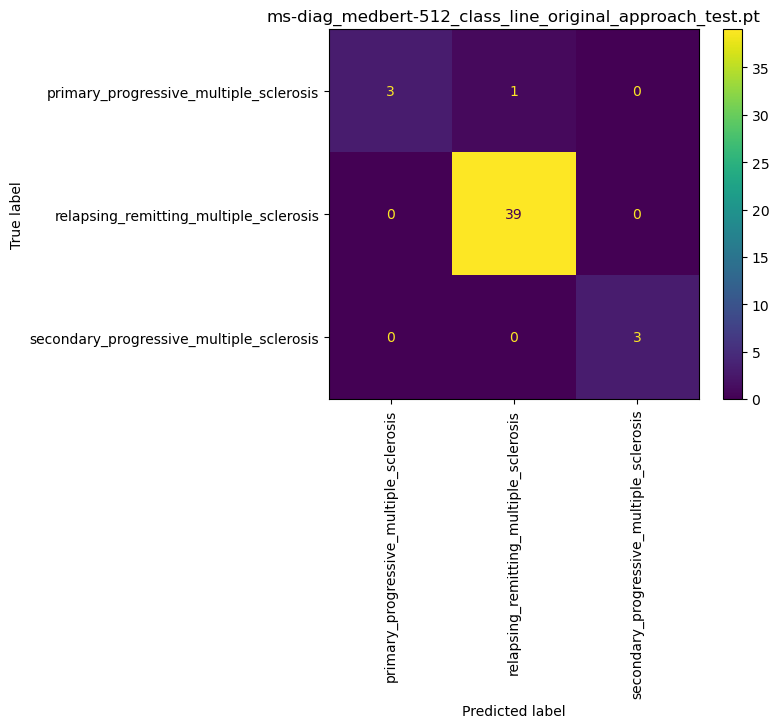

(46, 2)


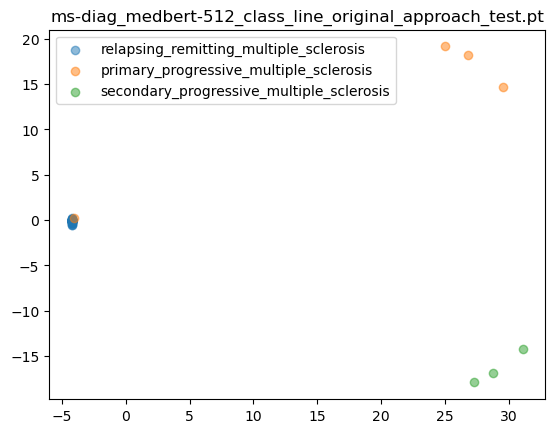

                                          precision    recall  f1-score   support

  primary_progressive_multiple_sclerosis       1.00      0.75      0.86         4
  relapsing_remitting_multiple_sclerosis       0.97      1.00      0.99        39
secondary_progressive_multiple_sclerosis       1.00      1.00      1.00         3

                                accuracy                           0.98        46
                               macro avg       0.99      0.92      0.95        46
                            weighted avg       0.98      0.98      0.98        46
 


Label: primary_progressive_multiple_sclerosis - Prediction: relapsing_remitting_multiple_sclerosis
v.v Primar progrediente multiple Sklerose 




In [4]:
show_results("ms-diag_medbert-512_class_line_original_approach_test.pt")

## Strategy: Classify on whole report, 4 labels (including no ms) triaining on oversampled

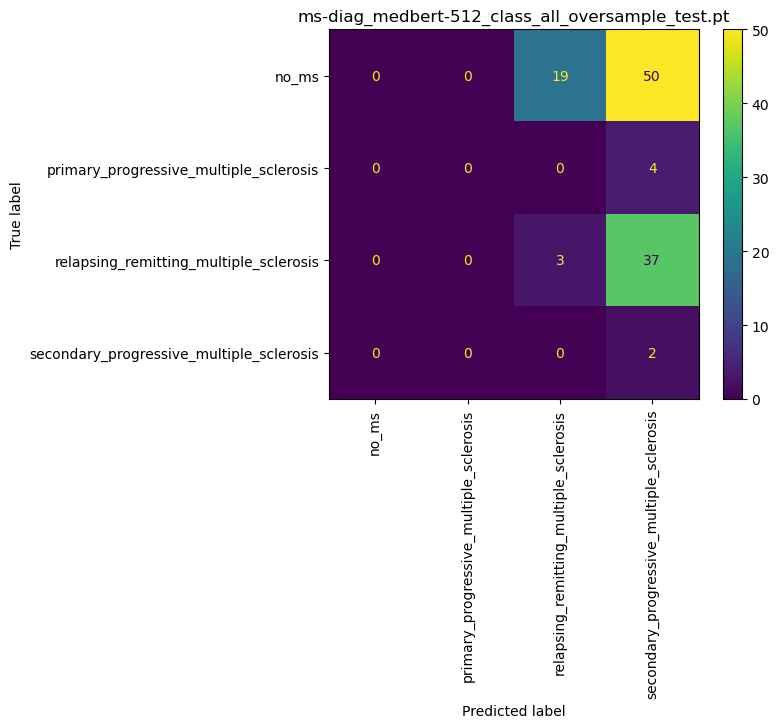

(115, 2)


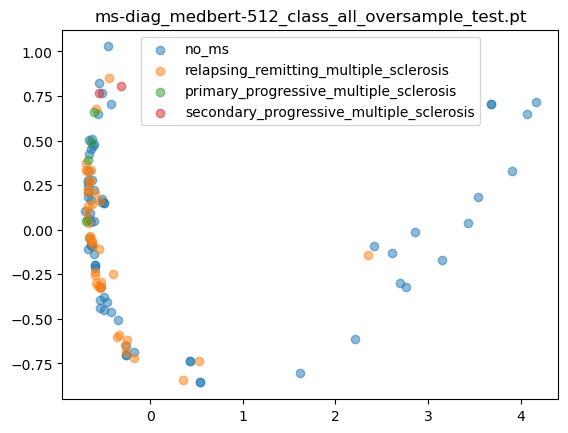

                                          precision    recall  f1-score   support

                                   no_ms       0.00      0.00      0.00        69
  primary_progressive_multiple_sclerosis       0.00      0.00      0.00         4
  relapsing_remitting_multiple_sclerosis       0.14      0.07      0.10        40
secondary_progressive_multiple_sclerosis       0.02      1.00      0.04         2

                                accuracy                           0.04       115
                               macro avg       0.04      0.27      0.03       115
                            weighted avg       0.05      0.04      0.03       115
 


Label: no_ms - Prediction: relapsing_remitting_multiple_sclerosis
St. n. Bimaxilläre Retrognathie mit/bei:
INDENT St. n. Le Fort I Osteotomie und sagittale Spaltung Unterkiefer beidseits am 08.02.2011 


Label: no_ms - Prediction: secondary_progressive_multiple_sclerosis
Aktuell (02/2019): Klinisch nicht aktiv, radiologisch aktiv,  Prog

/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

In [7]:
show_results("ms-diag_medbert-512_class_all_oversample_test.pt")

## Strategy: Classify on whole report, 3 Labels (original approach with only reports containing at least one dm line), oversampling for training

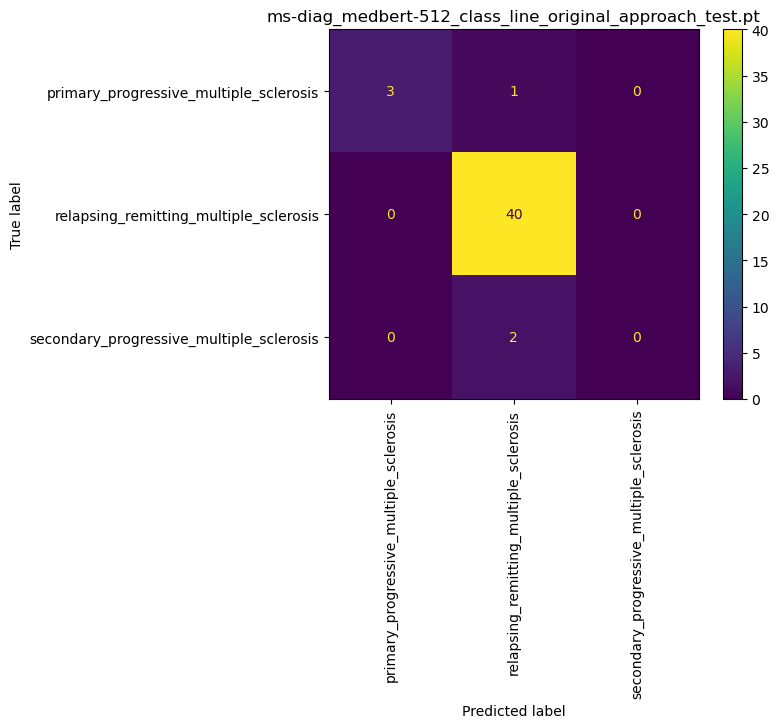

(46, 2)


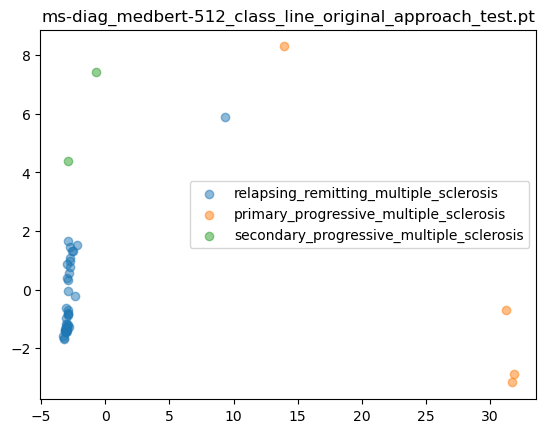

                                          precision    recall  f1-score   support

  primary_progressive_multiple_sclerosis       1.00      0.75      0.86         4
  relapsing_remitting_multiple_sclerosis       0.93      1.00      0.96        40
secondary_progressive_multiple_sclerosis       0.00      0.00      0.00         2

                                accuracy                           0.93        46
                               macro avg       0.64      0.58      0.61        46
                            weighted avg       0.90      0.93      0.91        46
 


Label: primary_progressive_multiple_sclerosis - Prediction: relapsing_remitting_multiple_sclerosis
1. Primär progrediente Multiple Sklerose, EM 1992, ED 1996, aktuell EDSS 7.0
INDENT Verlauf: Erstmanifestation mit Sensibilitätsstörungen am rechten Bein. Seitdem progrediente Beinschwäche sowie Extremitätenataxie, im gesamten Krankheitsverlauf kein Hinweis auf schubverdächtige Episoden
INDENT Klinisch aktuell: Sakkadie

/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

In [9]:
show_results("ms-diag_medbert-512_class_line_original_approach_test.pt")